### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 1: Credit Analytics

### Team members: Valente Francesco, Skorkowski Tomasz, Schaufelbühl Andreas

In [2]:
%%capture
!pip install keras==3.1.1 -qq
!pip install tensorflow.keras.callbacks -qq

In [3]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
### Fix random seed for reproducibility
np.random.seed(10)

# Exercise 1. Dataset features generation.

In [5]:
# Data set params
age_lower_bound = 18
age_upper_bound = 80.000001

income_lower_bound = 1
income_upper_bound = 15.000001

p_self_employed = .1

# train set power
m = int(2e4)
# test set power
n = int(1e4)

feature_headers = ['age', 'income', 'self_employed']

# Age ,income and employment data
data = pd.DataFrame((np.random.uniform(age_lower_bound,age_upper_bound, m+n),
                     np.random.uniform(income_lower_bound,income_upper_bound, m+n),
                     np.random.binomial(1, p_self_employed, size = m+n))).transpose()
data.columns=feature_headers

# Set up df to collect results and corresponding losses
df_results = pd.DataFrame(columns=['model', 'test_loss', 'train_loss'])

### Investigate generated features

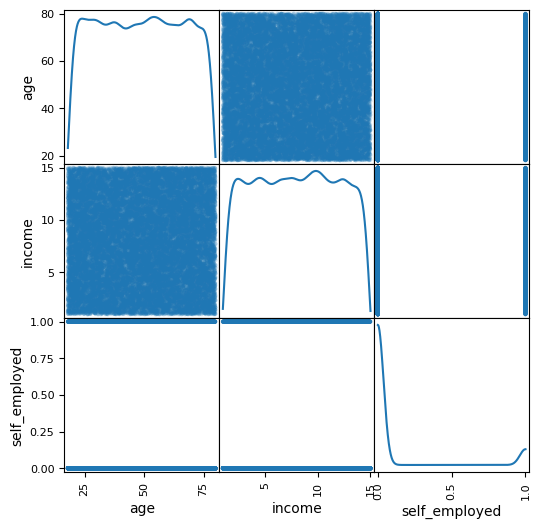

In [6]:
# Plot scatter matrix
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(6, 6),diagonal='kde')
plt.show()

1. We can observe that features have aproximately distributions as specified in the requirements
2. Graphs do not show any obvious correlation between covariates

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

normalized_data.cov()

,age,income,self_employed
age,1.000033,0.004466,-0.000978
income,0.004466,1.000033,0.001806
self_employed,-0.000978,0.001806,1.000033


Also covariance matrix of standarised features show no correlation between the fetures. This is to be expected given that the variables were simulated independently, ie. as instructed.

Lets look at the distributinos of individual features

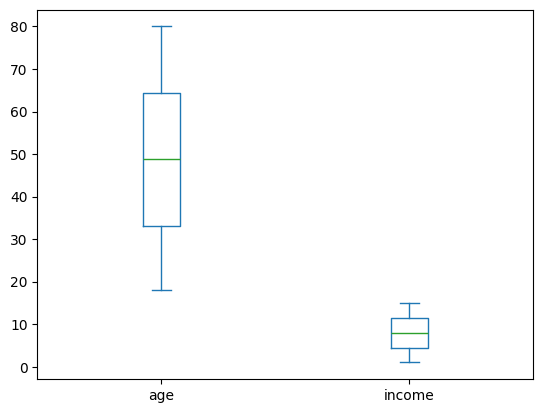

In [8]:
data[['age', 'income']].plot(kind='box')
plt.show()

In [9]:
data[['self_employed']].value_counts(normalize=True)

self_employed
0.0              0.898967
1.0              0.101033
Name: proportion, dtype: float64

In [10]:
data.describe()

,age,income,self_employed
count,30000.000000,30000.000000,30000.000000
mean,48.844797,7.987606,0.101033
std,17.965029,4.026278,0.301378
min,18.004268,1.000025,0.000000
25%,33.195964,4.498722,0.000000
50%,48.927875,7.995084,0.000000
75%,64.411589,11.453036,0.000000
max,79.999369,14.999594,1.000000


Conclusion: data has been generated according to the specification

# Exercise 2. Dataset labels generation.

In [11]:
# Define logistic function
def logistic(z:float) -> float:
    return 1 / (1 + np.exp(-z))

# Define p1 parameters and function
p1_intecept = -13.3
p1_coeff = np.array([0.33,-3.5,3])

def p1(intecept: float, coeff: float, row:float) -> float:
    z = intecept + np.dot(coeff, row)
    return logistic(z)

# Define p2 parameters and function
p2_intecept = -5
p2_coeff = np.array([10,-1.1,1])
age_lower_bound_p2 = 25
age_upper_bound_p2 = 75


#function returning (indicator) function with specific lower and upper boundary
def indic(low_bound: float, up_bound: float):
    assert low_bound <= up_bound, 'lower boundry has to be less or equal to upper boundry'
    def arg(x):
        return 1 if x < low_bound or x > up_bound else 0
    return arg

# Define indicator function returning 1 below lower_bound (25),
# or above upper_bound (75) and 0 in between
p2_indicator = indic(age_lower_bound_p2, age_upper_bound_p2)

def p2(intecept: float, coeff: float, row:float, indicator:indic)-> float:

    row_trasformed = row.copy()
    # Transform age (x_1) into x'_1 applying indicator function
    # ie x'_1(x1) = 1_(−∞,25)(x1) − 1_(75,∞)(x1)
    row_trasformed.loc['age'] = p2_indicator(row_trasformed.loc['age'])

    # take a linear combination of x'_1, x_2, x_3 and coefficients of p2
    z = intecept + np.dot(coeff, row_trasformed)
    return logistic(z)

$\psi(-5 + 10[1_{(-\infty,25)}(x_1)+ 1_{(75,\infty)}(x_1)] - 1.1x_2 + x_3) = \psi(-5 + 10x'_1 - 1.1x_2 + x_3)$

where

$x'_1 = 1_{(-\infty,25)}(x_1)+ 1_{(75,\infty)}(x_1)$

In [12]:
df_prob = pd.DataFrame()
df_prob['p_1'] = data.apply(lambda row: p1(p1_intecept, p1_coeff, row), axis = 1)
df_prob['p_2'] = data.apply(lambda row: p2(p2_intecept, p2_coeff, row, p2_indicator), axis = 1)

df_prob.describe()

,p_1,p_2
count,3.000000e+04,3.000000e+04
mean,5.039505e-02,5.208224e-02
std,1.953120e-01,1.914536e-01
min,1.115391e-26,4.601111e-10
25%,8.564344e-17,6.625024e-08
50%,1.575547e-11,7.143739e-06
75%,2.932197e-06,3.776501e-04
max,9.999963e-01,9.924480e-01


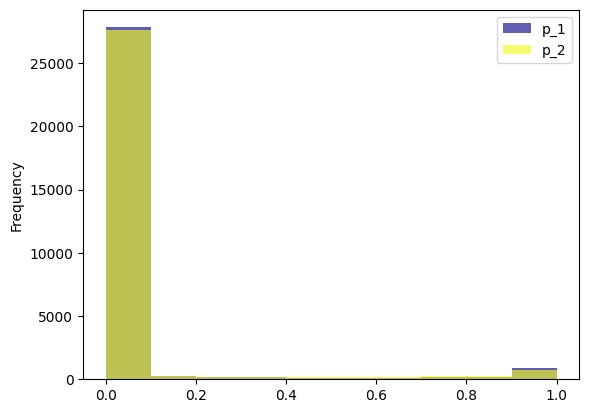

In [13]:
df_prob.plot(kind='hist', colormap='plasma', alpha = .65)
plt.show()

In [14]:
df_default = pd.DataFrame()
for i, col in enumerate(df_prob.columns):
    df_default['y_'+str(i+1)] = np.random.binomial(1, df_prob[col])

In [15]:
# Split into test train datasets
X_train = data.loc[:m-1]
X_test = data.loc[m:]

Y_train = df_default.loc[:m-1]
Y_test = df_default.loc[m:]

In [16]:
print('Summary:',
       df_default.value_counts(['y_1'], normalize=True),
       df_default.value_counts(['y_2'], normalize=True),
       sep='\n')

Summary:
y_1
0      0.948633
1      0.051367
Name: proportion, dtype: float64
y_2
0      0.948567
1      0.051433
Name: proportion, dtype: float64


# Exercise 3. Model implementations.

In [17]:
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # Cross-entropy
from typing import Union

import keras

In [18]:
# For comaprison log loss based on the naive prediction (ie. frequency in Y_train data)
naive_pred_1 = Y_train['y_1'].value_counts(normalize=True)[1]
naive_pred_2 = Y_train['y_2'].value_counts(normalize=True)[1]

log_loss_naive_1_train = log_loss(Y_train['y_1'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_1_test = log_loss(Y_test['y_1'], [naive_pred_1] * Y_test.shape[0])

print((f'''
Naive probability prediction based on the frequency in p_1: {naive_pred_1}
Log loss based on naive prediction, train data: {log_loss_naive_1_train}
Log loss based on naive prediction, test data: {log_loss_naive_1_test}
'''))

log_loss_naive_2_train = log_loss(Y_train['y_2'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_2_test = log_loss(Y_test['y_2'], [naive_pred_1] * Y_test.shape[0])

print((f'''
Naive probability prediction based on the frequency in p_2: {naive_pred_2}
Log loss based on naive prediction, train data: {log_loss_naive_2_train}
Log loss based on naive prediction, test data: {log_loss_naive_2_test}
'''))

df_results.loc[len(df_results.index)] = ['Naive', log_loss_naive_2_test, log_loss_naive_2_train]


Naive probability prediction based on the frequency in p_1: 0.0514
Log loss based on naive prediction, train data: 0.20261700624514914
Log loss based on naive prediction, test data: 0.20232547134105094


Naive probability prediction based on the frequency in p_2: 0.0509
Log loss based on naive prediction, train data: 0.20115933172465794
Log loss based on naive prediction, test data: 0.20582389019022976



In [19]:
# Given that we know the true distribution compute ireducible error/loss on train/test sets

log_loss_irreducible_1_train = log_loss(Y_train['y_1'], df_prob['p_1'][:m])
log_loss_irreducible_1_test = log_loss(Y_test['y_1'], df_prob['p_1'][m:])

print(f'''
Irreducible error in y_1
True error on the training data: {log_loss_irreducible_1_train}
True error on the test data: {log_loss_irreducible_1_test}
''')

log_loss_irreducible_2_train = log_loss(Y_train['y_2'], df_prob['p_2'][:m])
log_loss_irreducible_2_test = log_loss(Y_test['y_2'], df_prob['p_2'][m:])

print(f'''
Irreducible error in y_2
True error on the training data: {log_loss_irreducible_2_train}
True error on the test data: {log_loss_irreducible_2_test}
''')

df_results.loc[len(df_results.index)] = ['True', log_loss_irreducible_2_test, log_loss_irreducible_2_train]


Irreducible error in y_1
True error on the training data: 0.03226197926237395
True error on the test data: 0.03477630156060681


Irreducible error in y_2
True error on the training data: 0.041199726500333565
True error on the test data: 0.042955581488156654



### 3a) Logistic regression (LR)

In [20]:
# Create container for the model and it's main characteristics
from sklearn.linear_model import LogisticRegression
import textwrap

class MlModelClassification():
    def __init__(self,
                 name: str,
                 model: Union[LogisticRegression, keras.src.models.sequential.Sequential]):
        self._name = name
        self._model = model
        self._type = type(model)

    @property
    def model(self) -> float:
        return self._model

    @property
    def model_type(self) -> str:
        return self._type

    @property
    def log_loss_train(self) -> float:
        return self._log_loss_train

    @log_loss_train.setter
    def log_loss_train(self, loss: float):
        self._log_loss_train = loss

    @property
    def log_loss_test(self) -> float:
        return self._log_loss_test

    @log_loss_test.setter
    def log_loss_test(self, loss: float):
        self._log_loss_test = loss

    def __str__(self):
        return textwrap.dedent(f'''
                ML model: {self._name}
                Type: {self._type}
                Log loss on the training data: {self._log_loss_train:.4f}
                Log loss on the test data: {self._log_loss_test:.4f}''')

class LrModel(MlModelClassification):
    def __init__(self, name: str, model: LogisticRegression):
        super().__init__(name, model)

    def __str__(self):
        return textwrap.dedent(f'''{super().__str__()}
                               Coefficients: {self._model.coef_}
                               Intercept: {self._model.intercept_}''')

class NnModel(MlModelClassification):
    def __init__(self, name: str, model: keras.src.models.sequential.Sequential):
        super().__init__(name, model)

    @property
    def history(self) :
        return self._history

    @history.setter
    def history(self, history):
        self._history = history

In [21]:
# Implement and train a logistic regression model
# You can use LogisticRegression() from sklearn.linear_model (see the notebook "Project 1 - Sandbox.ipynb")
# For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Attention! Set the argument penalty=None to implement a logistic regression without regularization
lr_models = []
for i, col in enumerate(Y_train.columns):
    lr = LrModel(name = 'LR_Default_'+ str(i+1),
                  model = LogisticRegression(penalty=None).fit(X_train, Y_train[col]))
    lr.log_loss_train = log_loss(Y_train[col], lr.model.predict_proba(X_train)[:,1])
    lr.log_loss_test = log_loss(Y_test[col], lr.model.predict_proba(X_test)[:,1])
    lr_models.append(lr)

df_results.loc[len(df_results.index)] = ['LR', lr.log_loss_test, lr.log_loss_train]

In [22]:
# ICE plots
sample = np.random.randint(low = 0, high = X_test.shape[0],size=20)


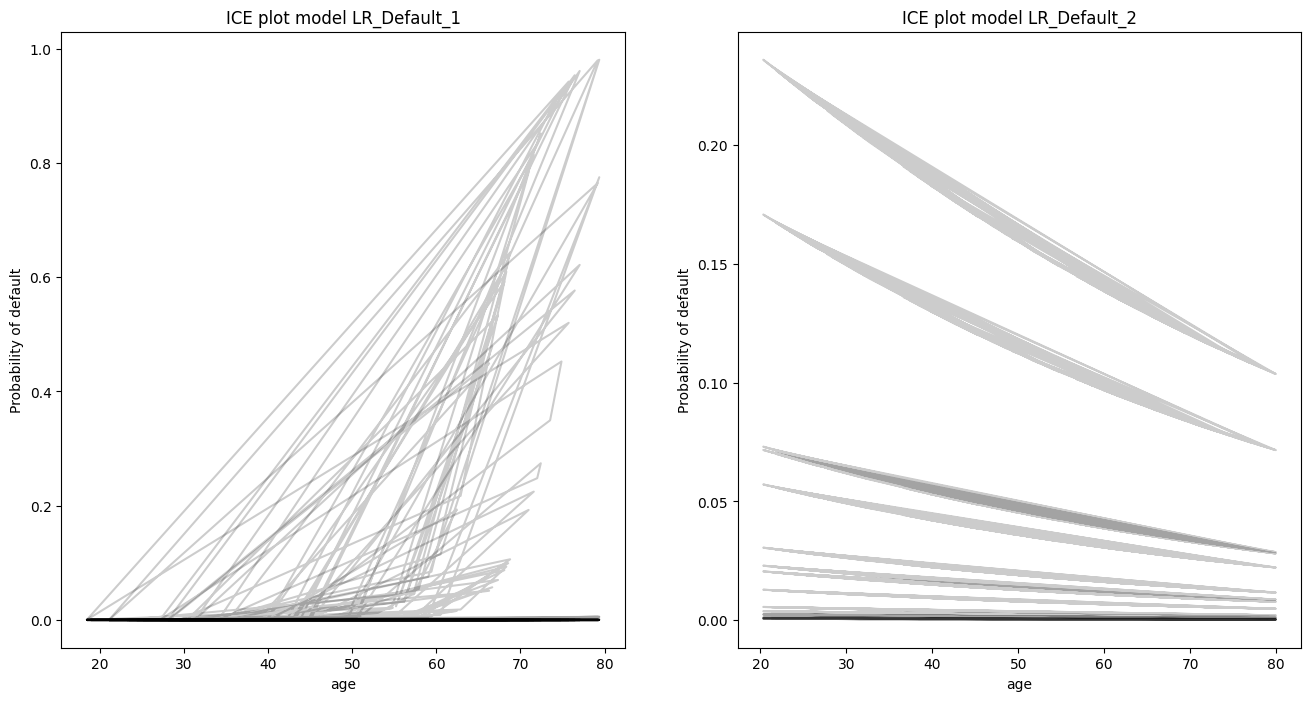

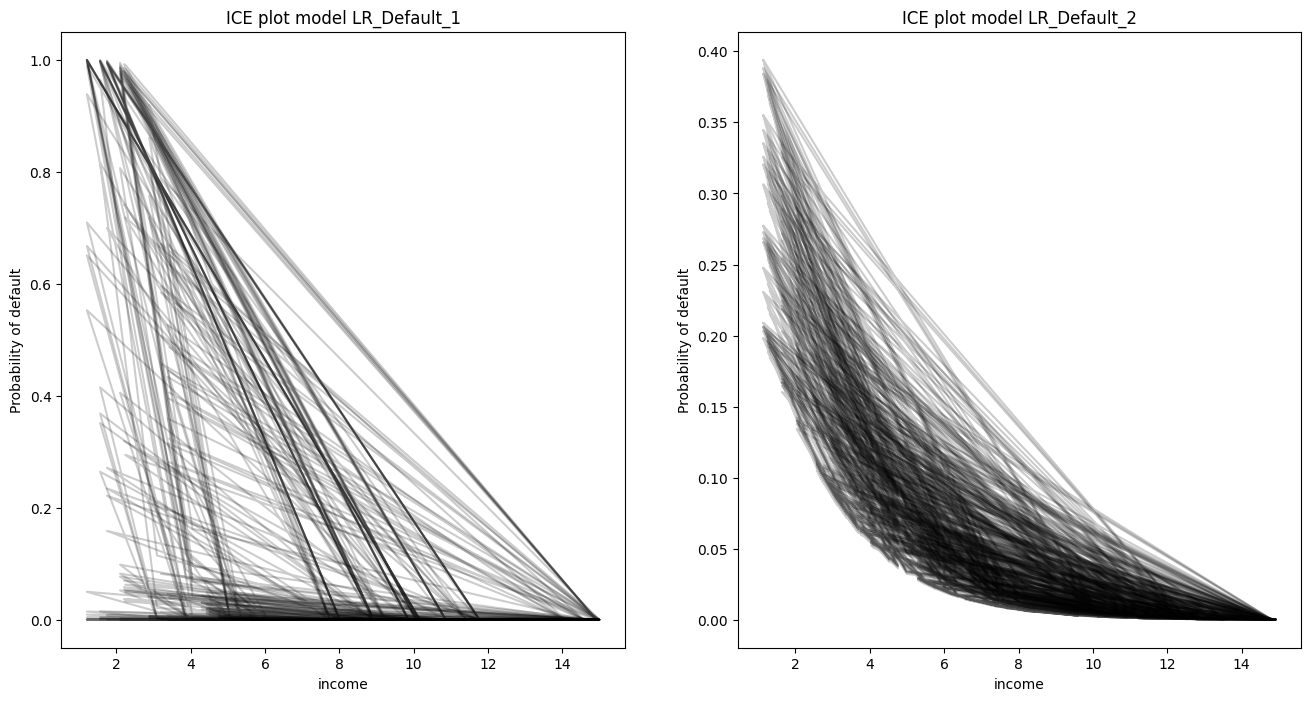

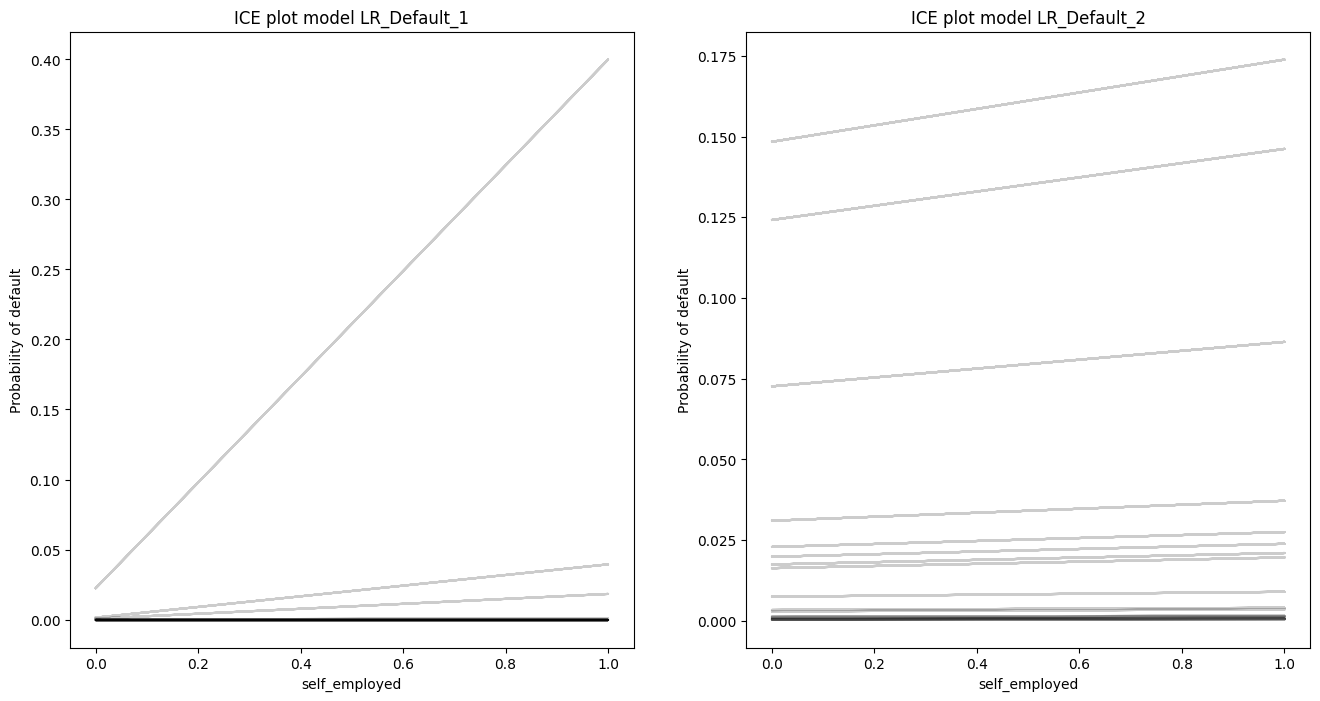

In [23]:
for feature in feature_headers:
  fig, ax = plt.subplots(1,2,figsize= [16, 8])
  for i, col in enumerate(Y_train.columns):
    model = lr_models[i].model
    sample_range = X_train[feature].sample(n=80, replace=False)
    for k in sample:
      df_ice = pd.DataFrame([X_test.iloc[k]] * len(sample_range))
      df_ice[feature] = np.array(sample_range)
      ax[i].plot(df_ice[feature],model.predict_proba(df_ice)[:,1], c='black', alpha=.2)
    ax[i].set_ylabel('Probability of default')
    ax[i].set_xlabel(f'{feature}')
    ax[i].set_title(f'ICE plot model {lr_models[i]._name}')
plt.show()


In [24]:
# Compute the cross-entropy loss on the training and test data.
for i, lr in enumerate(lr_models):
    print(lr)


ML model: LR_Default_1
Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Log loss on the training data: 0.0319
Log loss on the test data: 0.0356
                               Coefficients: [[ 0.31819676 -3.48603826  3.37099418]]
                               Intercept: [-12.41238575]

ML model: LR_Default_2
Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Log loss on the training data: 0.1505
Log loss on the test data: 0.1581
                               Coefficients: [[-0.01646936 -0.51820434  0.18873206]]
                               Intercept: [0.47918133]


Comments:

p1
    
* Logistic regression learned intercept and covariates well in p1 case
* Cross entropy from the logistic regression in close to the true error - we can't du much better

p2

* With non linearity in the model, logistic regression based on linear predictor has problems with finding good parameters
* We can observe that the true error is much lower than either LR train or test error
* Both models perform better than naive model - phew!

### 3b) Neural network (NN)

In [25]:
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 1 - Credit risk - Sandbox")
# For more information, see: https://keras.io/getting_started/


nn_names = [f'Neural_network_{i}' for i in range(1,3)]

In [26]:
# Lets train NN as long as performance on the test set is improving
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
nn_models = []

In [28]:
# NN 1
model = 0

# Number of neurons in the hidden layer
neuron_count_1 = 50
batch_size_1 = 1024 # Size of batches in stochastic gradient descent
epochs_1 = 500 # Number of iterations on dataset
lr_1 = 0.00035 # learning rate

# Architecture NN_1
nn_name = nn_names[model]
locals()[nn_name] = keras.Sequential([keras.layers.Dense(neuron_count_1, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_1, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_1, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_1, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')])

# Compile the network
# We choose Adam as gradient descent algorithm and cross-entropy as loss function
locals()[nn_name].compile(optimizer=keras.optimizers.Adam(learning_rate=lr_1),
                    loss=keras.losses.BinaryCrossentropy())

nn_model = NnModel('NN_Default_'+ str(1),
                    model = locals()[nn_name])
nn_models.append(nn_model)

In [29]:
# Train the model 1
model_choice = 0
nn_models[model_choice].model.fit(x=X_train,
                                  y=Y_train.iloc[:,model_choice],
                                  validation_split=0.2,
                                  batch_size=batch_size_1,
                                  callbacks=[early_stopping_1],
                                  epochs=epochs_1)

Epoch 1/500


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3428 - val_loss: 1.2657
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2301 - val_loss: 1.1688
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1367 - val_loss: 1.0832
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0567 - val_loss: 1.0063
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9872 - val_loss: 0.9396
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9160 - val_loss: 0.8794
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8599 - val_loss: 0.8276
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8083 - val_loss: 0.7815
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7664 - val_loss: 0.7374
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7217 - val_loss: 0.6970
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6833 - val_loss: 0.6591
Epoch 12/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6449 - val_l

In [30]:
# NN 2
model = 1

# Number of neurons in the hidden layer
neuron_count_2 = 60
batch_size_2 = 1024 # Size of batches in stochastic gradient descent
epochs_2 = 500 # Number of iterations on dataset
lr_2 = 0.00025 # learning rate

# Architecture NN_1
nn_name = nn_names[model]
locals()[nn_name] = keras.Sequential([keras.layers.Dense(neuron_count_2, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_2, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_2, kernel_regularizer=l2(0.01), activation='relu'),
                                    keras.layers.Dense(neuron_count_2, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')])

# Compile the network
# We choose Adam as gradient descent algorithm and cross-entropy as loss function
locals()[nn_name].compile(optimizer=keras.optimizers.Adam(learning_rate=lr_2),
                    loss=keras.losses.BinaryCrossentropy())

nn_model = NnModel('NN_Default_'+ str(2),
                    model = locals()[nn_name])
nn_models.append(nn_model)

In [31]:
# Train the model 2
model_choice = 1
nn_models[model_choice].model.fit(x=X_train,
                                  y=Y_train.iloc[:,model_choice],
                                  validation_split=0.2,
                                  batch_size=batch_size_2,
                                  callbacks=[early_stopping_2],
                                  epochs=epochs_2)

Epoch 1/500


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4149 - val_loss: 1.3562
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3343 - val_loss: 1.2941
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2781 - val_loss: 1.2370
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2271 - val_loss: 1.1875
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1738 - val_loss: 1.1385
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1303 - val_loss: 1.0933
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0805 - val_loss: 1.0491
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0355 - val_loss: 1.0077
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9956 - val_loss: 0.9684
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9586 - val_loss: 0.9307
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9261 - val_loss: 0.8948
Epoch 12/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8842 - val_l

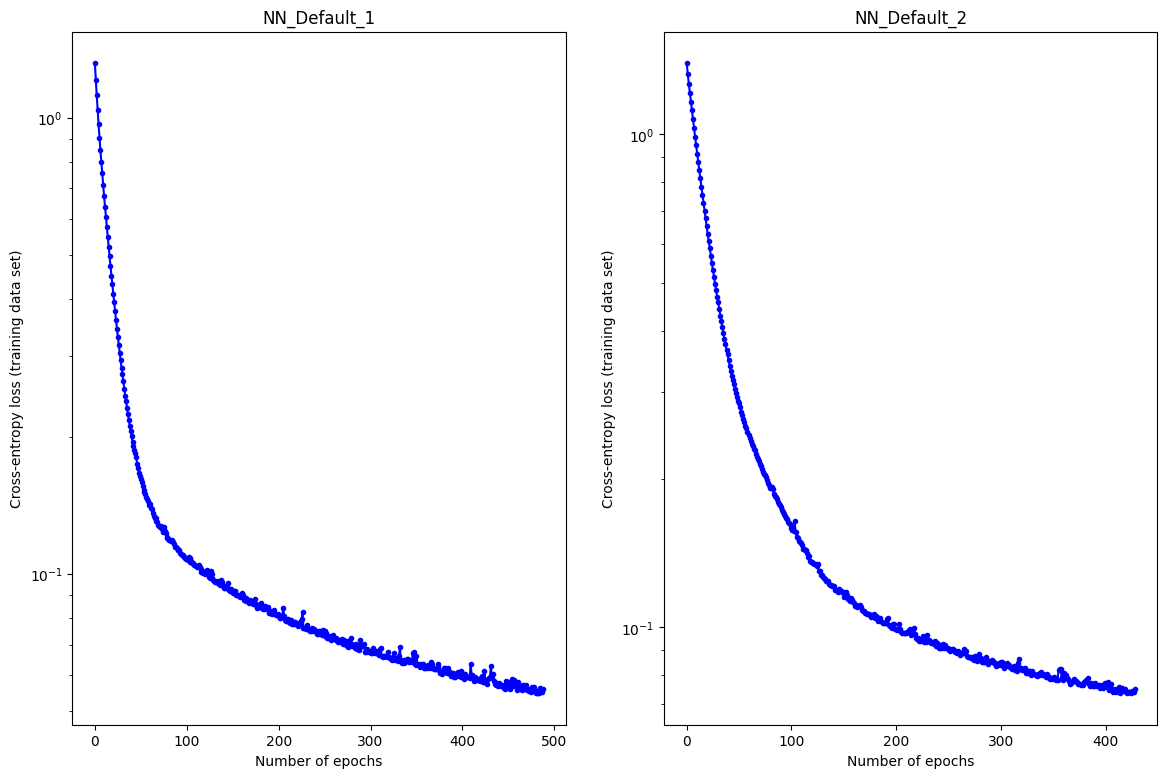

In [32]:
# Plot the cross-entropy loss during training
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(14,9))
for i, nn in enumerate(nn_models):
    hist = nn.model.history
    ax[i].plot(hist.history['loss'], 'b.-')
    ax[i].set_title(nn._name)

    ax[i].set_yscale('log')
    ax[i].set_ylabel('Cross-entropy loss (training data set)')
    ax[i].set_xlabel('Number of epochs')
plt.show()

In [33]:
# Compute the cross-entropy loss on the training and test data.
for i, nn in enumerate(nn_models):
    nn.log_loss_train = log_loss(Y_train.iloc[:,i], nn.model.predict(X_train))
    nn.log_loss_test = log_loss(Y_test.iloc[:,i], nn.model.predict(X_test))
    print(nn)
df_results.loc[len(df_results.index)] = ['NeuralNet', nn.log_loss_test, nn.log_loss_train]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step

ML model: NN_Default_1
Type: <class 'keras.src.models.sequential.Sequential'>
Log loss on the training data: 0.0328
Log loss on the test data: 0.0352
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step

ML model: NN_Default_2
Type: <class 'keras.src.models.sequential.Sequential'>
Log loss on the training data: 0.0547
Log loss on the test data: 0.0568


In [34]:
#Lets look at combined results on non_linear problem
df_results.sort_values(by='train_loss', ascending = False)

,model,test_loss,train_loss
0,Naive,0.205824,0.201159
2,LR,0.158055,0.150504
3,NeuralNet,0.056797,0.054738
1,True,0.042956,0.041200


Comments:

* NN_Default_1 is slightly worse when compared to LR_Default_1
* NN_Default_2 seems to perform well, ie much better than logistic regression

### 3c) ROC curves and AUC scores

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


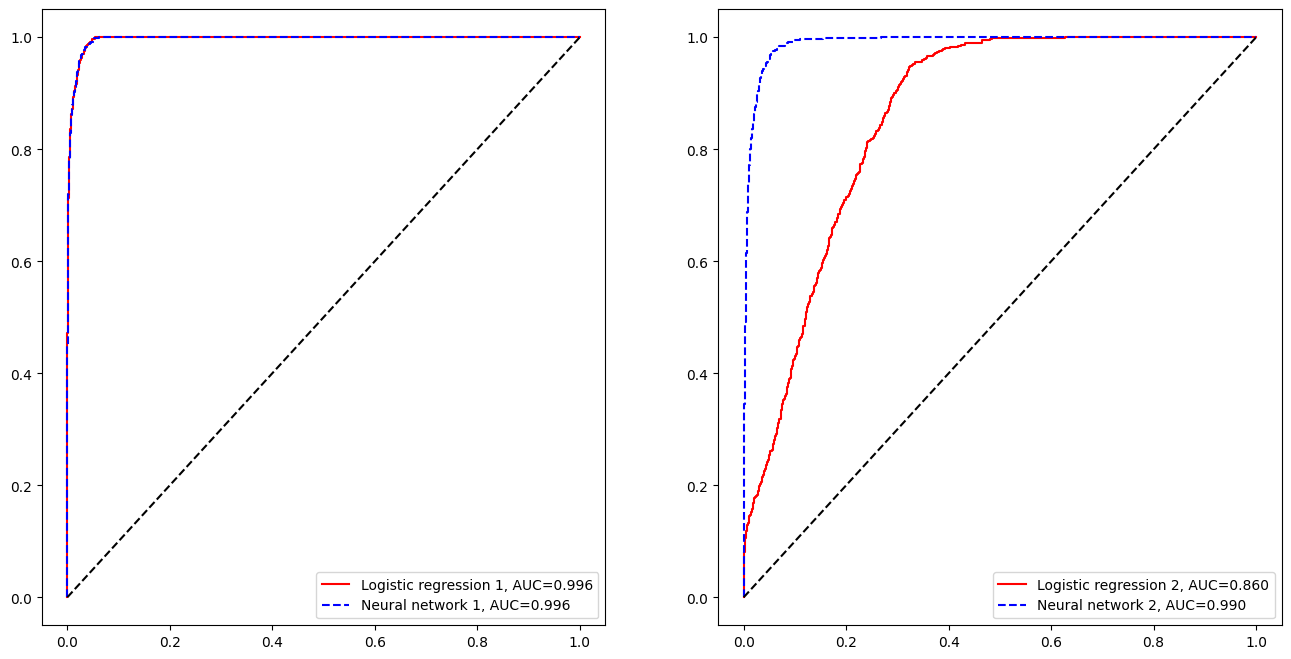

In [35]:
# Plot the ROC curves and compute the AUC scores
# You can use roc_auc_score and roc_curve from sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Select models for comaprison

fig, ax = plt.subplots(1,2,figsize= [16, 8])

for model in range(2):
    fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test.iloc[:,model], lr_models[model].model.predict_proba(X_test)[:, 1], pos_label=1)
    auc_LR = roc_auc_score(Y_test.iloc[:,model], lr_models[model].model.predict_proba(X_test)[:, 1])

    # Compute FPR and TPR for neural network
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(Y_test.iloc[:,model], nn_models[model].model.predict(X_test), pos_label=1)
    auc_NN = roc_auc_score(Y_test.iloc[:,model], nn_models[model].model.predict(X_test))

    # Create plot
    ax[model].plot(fpr_LR, tpr_LR, 'r-', label=f'Logistic regression {model + 1}, AUC={auc_LR:.3f}') #.format(auc_LR)
    ax[model].plot(fpr_NN, tpr_NN, 'b--', label=f'Neural network {model + 1}, AUC={auc_NN:.3f}') #.format(auc_NN)
    ax[model].plot([0, 1], [0, 1], 'k--')
    ax[model].legend()

plt.show()

# Exercise 4. Comparison of lending strategies

In [36]:
# Implement a function to compute the Value at Risk (VaR) at level alpha on the vector x
def var(x, alpha):
    return np.quantile(x,alpha)

In [37]:
# Simulate scenario matrix
prob_set = 2 # Which set of probabilities, defined at the start, are we interested in {1,2}

df_test_prob = df_prob.iloc[m:,prob_set-1] # p2, test subset of full probability matrix (ie corresponding to Y_test seconde column)

df_scenarios = pd.DataFrame()
num_cols = df_test_prob.shape[0]
num_rows = int(1e3)

# Create scenarios where 1 <=> default
df_scenarios_default = pd.DataFrame(np.random.binomial(1, p=df_test_prob,size=(num_rows, num_cols))).transpose()

# Transform default scenarios by swaping 1's and 0's to get matrix that can be used to calculate profit easily
df_scenarios = np.logical_not(df_scenarios_default).astype(int)

In [38]:
# Check scenarios, should be small. Cumulative difference of mean estimators and 10000 test set means (ie probability of a success in Bernouli trail)
(df_scenarios.sum(axis=1)/num_rows).sum() - (1-df_test_prob).sum()

0.36472393016447313

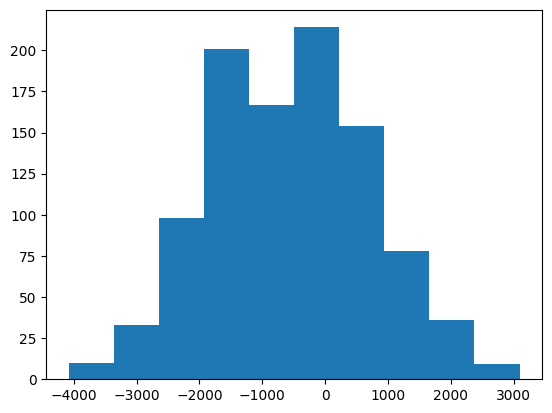

95% VaR of strategy (i): 2603.0


In [39]:
alpha = 0.95
# Implement strategy (i), plot the P&L histogram and compute VaR(95%) of the losses
ir = 5.5/100
loan = 100

investment = 100 * n

# Calculate return per scenario
return_t1 = [loan * (1 + ir)] * n @ df_scenarios

# Calculate profit&loss
P_L_1 = return_t1 - investment

plt.hist(P_L_1)
plt.show()
print(f'95% VaR of strategy (i): {var(-P_L_1, alpha)}')

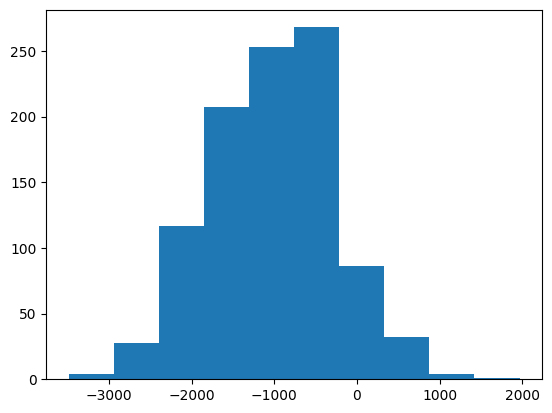

95% VaR of strategy (iii): 2275.0
Mean P&L of strategy (iii): -1037.851


In [40]:
# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses
ir = 1/100
loan = 100
application_treshold = 5/100

lr_model = lr_models[1].model
LR2_prob = lr_model.predict_proba(X_test)[:,1]

select_applicants = LR2_prob <= application_treshold

investment = 100 * sum(select_applicants)

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * sum(select_applicants)
                         @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_2 = return_t1 - investment

plt.hist(P_L_2)
plt.show()
print(f'''95% VaR of strategy (iii): {var(-P_L_2, alpha)}
Mean P&L of strategy (iii): {P_L_2.mean()[0]}''')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


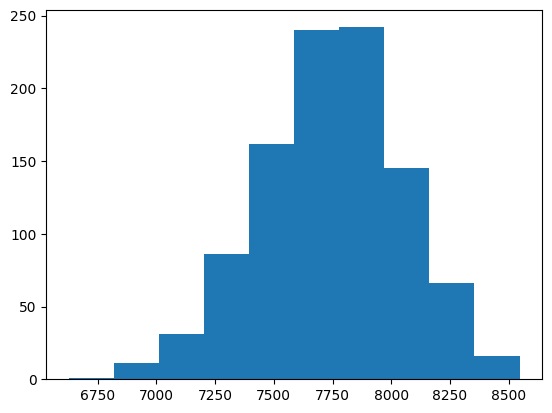

95% VaR of strategy (iii): -7233.0
Mean P&L of strategy (iii): 7753.554


In [41]:
# Implement strategy (iii), plot the P&L histogram and compute VaR(95%) of the losses

ir = 1/100
loan = 100
application_treshold = 5/100

nn_model = nn_models[1].model
nn2_prob = nn_model.predict(X_test)

select_applicants = nn2_prob <= application_treshold

investment = 100 * select_applicants.sum()

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * select_applicants.sum()
                          @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_3 = return_t1 - investment

plt.hist(P_L_3)
plt.show()
print(f'''95% VaR of strategy (iii): {var(-P_L_3, alpha)}
Mean P&L of strategy (iii): {P_L_3.mean()[0]}''')


In [ ]:
#Lets look again at combined results on non_linear problem
df_results.sort_values(by='train_loss', ascending = False)

,model,test_loss,train_loss
0,Naive,0.205824,0.201159
2,LR,0.158055,0.150504
3,NeuralNet,0.056625,0.054294
1,True,0.042956,0.041200


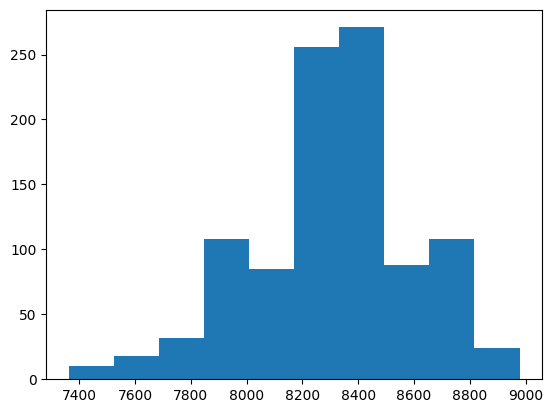

95% VaR of strategy (BestCase): -7766.0
Mean P&L of strategy (BestCase): 8298.27


In [48]:
# Best case scenario - ie we predict with probability p_2

ir = 1/100
loan = 100
application_treshold = 5/100

select_applicants = df_test_prob.reset_index(drop=True) <= application_treshold
investment = 100 * select_applicants.sum()

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * select_applicants.sum()
                          @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_4 = return_t1 - investment

plt.hist(P_L_4)
plt.show()
print(f'''95% VaR of strategy (BestCase): {var(-P_L_4, alpha)}
Mean P&L of strategy (BestCase): {P_L_4.mean()[0]}''')


### Comments

* In general business case it's very unlikely that covariates will be independent and that the conditional probability of deafult given features will be a simple linear combination.
* Consequently Neural Netowork is verly likely to outperform Logistic Regression in real world application.
* As we see on the basis of two comparable strategies better model leads to competitive advantage.
* Company with the best model can offer lower interest rate without sacrificing profit. Due to better conditions said company would also attract more customers and make even more profit as a consequence.
* **Note that same selection criteria but based on the model lead to an improvement in expected profit from -1037 to 7608 while eliminatinig downside risk!**
* Knowing the true distribution we know that at best we can only further decrese VaR@95% by 500
* With a good risk assesment company can make a sound decision about it's risk appetite and also offer loans to the more risky customers. In such case, copmany could also try to optimsie under soldarity/ethical conditions. Ie. not to limit to havily an access to the capital to the most disadventegous social groups.
